In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
def load_glaucoma_dataset(data_dir, image_size):
    images = []
    labels = []
    class_names = ['Glaucoma_Positive', 'Glaucoma_Negative']

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        class_label = class_names.index(class_name)

        for filename in os.listdir(class_dir):
            if filename.endswith(".jpg"):
                img_path = os.path.join(class_dir, filename)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (image_size, image_size))
                img = img / 255.0
                images.append(img)
                labels.append(class_label)

    return np.array(images), np.array(labels)

your_dataset_path = r"/content/drive/MyDrive/Dataset_Sardjito"
your_image_size = 224  # Change this to the size required by ResNet152V2

glaucoma_train_images, glaucoma_train_labels = load_glaucoma_dataset(os.path.join(your_dataset_path, 'train'), your_image_size)
glaucoma_test_images, glaucoma_test_labels = load_glaucoma_dataset(os.path.join(your_dataset_path, 'test'), your_image_size)

In [44]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras import models
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# Define your image size
your_image_size = 224  # Replace with your desired image size

# Load ResNetV2-152 pre-trained on ImageNet without the top classification layer
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(your_image_size, your_image_size, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create the model by adding custom layers on top of the pre-trained ResNetV2-152
model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(2048, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LambdaCallback
import tensorflow as tf

# Assuming your model is already defined and created here

# Compile the model before training
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Create the ModelCheckpoint callback with a dummy filepath
early_stopping = EarlyStopping(monitor='val_loss', patience=200, verbose=0, mode='min', restore_best_weights=True)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Dataset_Latihan/dummy_model.h5", monitor='val_loss',  mode='min', save_best_only=True, save_weights_only=False)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, min_delta=1e-4, mode='min')

# Custom callback to save the best model at the end of training
best_model_saver = LambdaCallback(on_epoch_end=lambda epoch, logs: model.save("/content/drive/MyDrive/Dataset_Latihan/best_model.h5", save_format="h5"))

# Use all callbacks in the training loop
history = model.fit(glaucoma_train_images, glaucoma_train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_data=(glaucoma_test_images, glaucoma_test_labels),
                    callbacks=[checkpoint, early_stopping, reduce_lr_loss, best_model_saver])

# Save the final model in the native Keras format
model.save("/content/drive/MyDrive/Dataset_Latihan/Try_model.h5")



Epoch 1/50
6/6 [==============================] - 60s 10s/step - loss: 2.1211 - accuracy: 0.7600 - val_loss: 0.6106 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 2/50
6/6 [==============================] - 25s 5s/step - loss: 0.4989 - accuracy: 0.7943 - val_loss: 0.4403 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/50
6/6 [==============================] - 30s 6s/step - loss: 0.3941 - accuracy: 0.8286 - val_loss: 0.3360 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 4/50
6/6 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.8571

KeyboardInterrupt: ignored

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_glaucoma_dataset_generator(dataset_path, image_size, batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary',  # Assuming it's a binary classification task
        shuffle=True  # Set to True if you want to shuffle the order of the images
    )

    # Retrieve the total number of samples
    num_samples = generator.samples

    return generator, num_samples

# Example usage:
your_dataset_path = r"/content/drive/MyDrive/Dataset_LAG"
your_image_size = 224
batch_size = 32

# Define the path to the training dataset
train_dataset_path = os.path.join(your_dataset_path, 'train')

# Create a generator for the training dataset
train_generator, num_train_samples = load_glaucoma_dataset_generator(train_dataset_path, your_image_size, batch_size)

Found 4409 images belonging to 2 classes.


In [46]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LambdaCallback

# Load glaucoma dataset using a generator
def load_glaucoma_dataset_generator(dataset_path, image_size, batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary',  # Assuming it's a binary classification task
        shuffle=True  # Set to True if you want to shuffle the order of the images
    )

    # Retrieve the total number of samples
    num_samples = generator.samples

    return generator, num_samples

# Example usage:
your_dataset_path = r"/content/drive/MyDrive/Dataset_Sardjito"
your_image_size = 224
batch_size = 32

# Define the path to the training dataset
train_dataset_path = os.path.join(your_dataset_path, 'train')

# Create a generator for the training dataset
train_generator, num_train_samples = load_glaucoma_dataset_generator(train_dataset_path, your_image_size, batch_size)

# Define the path to the testing dataset
test_dataset_path = os.path.join(your_dataset_path, 'test')

# Create a generator for the testing dataset
test_generator, num_test_samples = load_glaucoma_dataset_generator(test_dataset_path, your_image_size, batch_size)

# Assuming your model is already defined and created here

# Compile the model before training
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Create the ModelCheckpoint callback with a dummy filepath
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min', restore_best_weights=True)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Dataset_Latihan/dummy_model.h5", monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, verbose=1, min_delta=1e-4, mode='min')

# Custom callback to save the best model at the end of training
best_model_saver = LambdaCallback(on_epoch_end=lambda epoch, logs: model.save("/content/drive/MyDrive/Dataset_Latihan/best_model.h5", save_format="h5"))

# Use all callbacks in the training loop
history = model.fit(
    train_generator,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=num_test_samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr_loss, best_model_saver]
)

# Save the final model in the native Keras format
model.save("/content/drive/MyDrive/Dataset_Latihan/Try_model.h5")


Found 175 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Epoch 1/50
5/5 [==============================] - 50s 10s/step - loss: 1.3480 - accuracy: 0.6224 - val_loss: 2.5908 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/50
5/5 [==============================] - 58s 14s/step - loss: 0.5690 - accuracy: 0.8188 - val_loss: 1.2246 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/50
5/5 [==============================] - 24s 5s/step - loss: 0.4969 - accuracy: 0.8182 - val_loss: 1.2835 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 4/50
5/5 [==============================] - 21s 5s/step - loss: 0.4469 - accuracy: 0.8313 - val_loss: 1.9121 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 5/50
5/5 [==============================] - 17s 4s/step - loss: 0.4127 - accuracy: 0.8112 - val_loss: 1.3673 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 6/50
5/5 [==============================] - 21s 5s/step - loss: 0.3275 - accuracy: 0.8671 - val_loss: 1.9679 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 7/50


In [34]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os

def load_glaucoma_dataset_generator(dataset_path, image_size, batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary',  # Assuming it's a binary classification task
        shuffle=False  # Ensure that the order is preserved
    )

    # Retrieve the total number of samples
    num_samples = generator.samples

    return generator, num_samples

# Example usage:
your_dataset_path = r"/content/drive/MyDrive/Dataset_Latihan"
your_image_size = 224
batch_size = 32

# Define the path to the test dataset
test_dataset_path = os.path.join(your_dataset_path, 'test')

# Create a generator for the test dataset
test_generator, num_test_samples = load_glaucoma_dataset_generator(test_dataset_path, your_image_size, batch_size)

# Define the path to your pre-trained model
model_path = "/content/drive/MyDrive/Dataset_Latihan/dummy_model.h5"  # Change this to the path of your saved model

# Load the pre-trained model
loaded_model = load_model(model_path)

# Initialize variables for confusion matrix
all_true_labels = []
all_predicted_labels = []

# Calculate the total number of batches
total_batches = num_test_samples // batch_size

# Iterate over batches
for i in range(total_batches + 1):  # +1 to include the last batch
    batch_images, batch_labels = test_generator.next()

    # Perform predictions on the batch
    predictions = loaded_model.predict(batch_images)
    predicted_labels = np.round(predictions).flatten()

    # Append true and predicted labels for confusion matrix
    all_true_labels.extend(batch_labels)
    all_predicted_labels.extend(predicted_labels)

    # Calculate loading and prediction process
    process_percentage = (i + 1) / (total_batches + 1) * 100
    print(f"Processing: {process_percentage:.2f}%")

# Convert true and predicted labels to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Evaluate the model on the entire test set
test_loss, test_accuracy = loaded_model.evaluate(test_generator)

# Print test accuracy, test loss, confusion matrix, and classification report
print(f"\nTest Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
print(conf_matrix)
print("\nClassification Report:")
class_report = classification_report(all_true_labels, all_predicted_labels)
print(class_report)

# Save the confusion matrix
conf_matrix_save_path = "/content/drive/MyDrive/confusion_matrix.npy"
np.save(conf_matrix_save_path, conf_matrix)
print(f"\nConfusion Matrix saved at: {conf_matrix_save_path}")


Found 224 images belonging to 2 classes.
1/1 [==============================] - 2s 2s/step
Processing: 12.50%
1/1 [==============================] - 0s 55ms/step
Processing: 25.00%
1/1 [==============================] - 0s 76ms/step
Processing: 37.50%
1/1 [==============================] - 0s 57ms/step
Processing: 50.00%
1/1 [==============================] - 0s 41ms/step
Processing: 62.50%
1/1 [==============================] - 0s 38ms/step
Processing: 75.00%
1/1 [==============================] - 0s 39ms/step
Processing: 87.50%
1/1 [==============================] - 0s 51ms/step
Processing: 100.00%
7/7 [==============================] - 10s 1s/step - loss: 1.4491 - accuracy: 0.7411

Test Accuracy: 0.7410714030265808
Test Loss: 1.4490729570388794

Confusion Matrix:
[[180  22]
 [ 40  14]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85       202
         1.0       0.39      0.26      0.31        54

    accuracy

In [31]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os

def load_glaucoma_dataset_generator(dataset_path, image_size, batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary',  # Assuming it's a binary classification task
        shuffle=False  # Ensure that the order is preserved
    )

    # Retrieve the total number of samples
    num_samples = generator.samples

    return generator, num_samples

# Example usage:
your_dataset_path = r"/content/drive/MyDrive/Dataset_LAG"
your_image_size = 224
batch_size = 32

# Define the path to the test dataset
test_dataset_path = os.path.join(your_dataset_path, 'test')

# Create a generator for the test dataset
test_generator, num_test_samples = load_glaucoma_dataset_generator(test_dataset_path, your_image_size, batch_size)

# Define the path to your pre-trained model
model_path = "/content/drive/MyDrive/Dataset_Latihan/dummy_model.h5"  # Change this to the path of your saved model

# Load the pre-trained model
loaded_model = load_model(model_path)

# Initialize variables for confusion matrix
all_true_labels = []
all_predicted_labels = []

# Calculate the total number of batches
total_batches = num_test_samples // batch_size

# Iterate over batches
for i in range(total_batches + 1):  # +1 to include the last batch
    batch_images, batch_labels = test_generator.next()

    # Perform predictions on the batch
    predictions = loaded_model.predict(batch_images)
    predicted_labels = np.round(predictions).flatten()

    # Append true and predicted labels for confusion matrix
    all_true_labels.extend(batch_labels)
    all_predicted_labels.extend(predicted_labels)

    # Calculate loading and prediction process
    process_percentage = (i + 1) / (total_batches + 1) * 100
    print(f"Processing: {process_percentage:.2f}%")

# Convert true and predicted labels to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Evaluate the model on the entire test set
test_loss, test_accuracy = loaded_model.evaluate(test_generator)

# Print test accuracy, test loss, confusion matrix, and classification report
print(f"\nTest Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
print(conf_matrix)
print("\nClassification Report:")
class_report = classification_report(all_true_labels, all_predicted_labels)
print(class_report)

# Save the confusion matrix
conf_matrix_save_path = "/content/drive/MyDrive/confusion_matrix.npy"
np.save(conf_matrix_save_path, conf_matrix)
print(f"\nConfusion Matrix saved at: {conf_matrix_save_path}")


Found 243 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step
Processing: 12.50%
1/1 [==============================] - 0s 52ms/step
Processing: 25.00%
1/1 [==============================] - 0s 39ms/step
Processing: 37.50%
1/1 [==============================] - 0s 43ms/step
Processing: 50.00%
1/1 [==============================] - 0s 42ms/step
Processing: 62.50%
1/1 [==============================] - 0s 42ms/step
Processing: 75.00%
1/1 [==============================] - 0s 38ms/step
Processing: 87.50%
1/1 [==============================] - 2s 2s/step
Processing: 100.00%
8/8 [==============================] - 5s 225ms/step - loss: 1.5239 - accuracy: 0.6708

Test Accuracy: 0.6707819104194641
Test Loss: 1.523909091949463

Confusion Matrix:
[[155   2]
 [ 78   8]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.99      0.79       157
         1.0       0.80      0.09      0.17        86

    accuracy 

In [19]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os

def load_glaucoma_dataset_generator(dataset_path, image_size, batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary',  # Assuming it's a binary classification task
        shuffle=False  # Ensure that the order is preserved
    )

    # Retrieve the total number of samples
    num_samples = generator.samples

    return generator, num_samples

# Example usage:
your_dataset_path = r"/content/drive/MyDrive/Dataset_Latihan"
your_image_size = 224
batch_size = 32

# Define the path to the test dataset
test_dataset_path = os.path.join(your_dataset_path, 'test')

# Create a generator for the test dataset
test_generator, num_test_samples = load_glaucoma_dataset_generator(test_dataset_path, your_image_size, batch_size)

# Define the path to your pre-trained model
model_path = "/content/drive/MyDrive/dummy_model.h5"  # Change this to the path of your saved model

# Load the pre-trained model
loaded_model = load_model(model_path)

# Initialize variables for confusion matrix
all_true_labels = []
all_predicted_labels = []

# Calculate the total number of batches
total_batches = num_test_samples // batch_size

# Iterate over batches
for i in range(total_batches + 1):  # +1 to include the last batch
    batch_images, batch_labels = test_generator.next()

    # Perform predictions on the batch
    predictions = loaded_model.predict(batch_images)
    predicted_labels = np.round(predictions).flatten()

    # Append true and predicted labels for confusion matrix
    all_true_labels.extend(batch_labels)
    all_predicted_labels.extend(predicted_labels)

    # Calculate loading and prediction process
    process_percentage = (i + 1) / (total_batches + 1) * 100
    print(f"Processing: {process_percentage:.2f}%")

# Convert true and predicted labels to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Evaluate the model on the entire test set
test_loss, test_accuracy = loaded_model.evaluate(test_generator)

# Print test accuracy, test loss, confusion matrix, and classification report
print(f"\nTest Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
print(conf_matrix)
print("\nClassification Report:")
class_report = classification_report(all_true_labels, all_predicted_labels)
print(class_report)

# Save the confusion matrix
conf_matrix_save_path = "/content/drive/MyDrive/confusion_matrix.npy"
np.save(conf_matrix_save_path, conf_matrix)
print(f"\nConfusion Matrix saved at: {conf_matrix_save_path}")

Found 224 images belonging to 2 classes.


OSError: ignored

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_data(input_folder, output_folder, train_percent=0.9, test_percent=0.05, val_percent=0.05):
    # Create train, test, and val folders in the output directory
    train_folder = os.path.join(output_folder, 'train')
    test_folder = os.path.join(output_folder, 'test')
    val_folder = os.path.join(output_folder, 'val')

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)

    for class_folder in os.listdir(input_folder):
        input_class_folder = os.path.join(input_folder, class_folder)

        if os.path.isdir(input_class_folder):
            # Create class-specific train, test, and val folders
            train_class_folder = os.path.join(train_folder, class_folder)
            test_class_folder = os.path.join(test_folder, class_folder)
            val_class_folder = os.path.join(val_folder, class_folder)

            os.makedirs(train_class_folder, exist_ok=True)
            os.makedirs(test_class_folder, exist_ok=True)
            os.makedirs(val_class_folder, exist_ok=True)

            # List all files in the input folder
            all_files = os.listdir(input_class_folder)
            total_files = len(all_files)

            # Split files into train, test, and val sets
            train_files, test_val_files = train_test_split(all_files, test_size=(test_percent + val_percent), random_state=42)
            test_files, val_files = train_test_split(test_val_files, test_size=val_percent/(test_percent + val_percent), random_state=42)

            # Copy files to the corresponding class-specific folders
            for file_name in train_files:
                shutil.copy(os.path.join(input_class_folder, file_name), os.path.join(train_class_folder, file_name))

            for file_name in test_files:
                shutil.copy(os.path.join(input_class_folder, file_name), os.path.join(test_class_folder, file_name))

            for file_name in val_files:
                shutil.copy(os.path.join(input_class_folder, file_name), os.path.join(val_class_folder, file_name))

# Example usage:
input_folder = r"/content/drive/MyDrive/Dataset_Sardjito/Bare"
output_folder = r"/content/drive/MyDrive/Dataset_Sardjito"  # Change this to the desired output path

split_data(input_folder, output_folder)

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Define the path to your pre-trained model
model_path = r"/content/drive/MyDrive/Dataset_Latihan/Try_model.h5"  # Change this to the path of your saved model

# Load the pre-trained model
loaded_model = load_model(model_path)

# Assuming you have loaded your test datasets: glaucoma_test_images, glaucoma_test_labels

# Perform predictions on the test set
predictions = loaded_model.predict(glaucoma_test_images)
predicted_labels = np.round(predictions).flatten()

# Convert true labels to binary (assuming it's not binary already)
true_labels = np.array(glaucoma_test_labels).flatten()

# Evaluate the model on the test set
test_loss, test_accuracy = loaded_model.evaluate(glaucoma_test_images, glaucoma_test_labels)

# Print test accuracy, test loss, confusion matrix, and classification report
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))


NameError: ignored

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(glaucoma_test_images, glaucoma_test_labels, verbose=2)
print("Test accuracy:", test_acc)

# Make predictions on the test set
predictions = model.predict(glaucoma_test_images)
predicted_labels = np.round(predictions).flatten()

# Print classification report
print("Classification Report:")
print(classification_report(glaucoma_test_labels, predicted_labels))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(glaucoma_test_labels, predicted_labels))

7/7 - 1s - loss: 0.8860 - accuracy: 0.8571 - 1s/epoch - 214ms/step
Test accuracy: 0.8571428656578064
7/7 [==============================] - 4s 217ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.63      1.00      0.77        54
           1       1.00      0.81      0.90       170

    accuracy                           0.86       224
   macro avg       0.81      0.91      0.83       224
weighted avg       0.91      0.86      0.87       224

Confusion Matrix:
[[ 54   0]
 [ 32 138]]


In [ ]:
save_path = r"/content/drive/MyDrive/Dataset_Latihan"  # Specify your desired save path
model.save(save_path)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Save the model with the lowest validation loss
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, save_weights_only=False)

# Stop training if the validation loss does not improve for 3 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(glaucoma_train_images, glaucoma_train_labels,
                    epochs=20,  # Increase the number of epochs to allow early stopping to work
                    batch_size=32,
                    validation_data=(glaucoma_test_images, glaucoma_test_labels),
                    callbacks=[checkpoint, early_stopping])


Epoch 1/100
14/14 [==============================] - 18s 671ms/step - loss: 0.5654 - accuracy: 0.7287 - val_loss: 0.4862 - val_accuracy: 0.8125
Epoch 2/100
14/14 [==============================] - 5s 359ms/step - loss: 0.5404 - accuracy: 0.7448 - val_loss: 0.4352 - val_accuracy: 0.8214
Epoch 2: early stopping


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Save the model with the lowest validation loss
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, save_weights_only=False)

history = model.fit(glaucoma_train_images, glaucoma_train_labels,
                    epochs=5,
                    batch_size=32,
                    validation_data=(glaucoma_test_images, glaucoma_test_labels),
                    callbacks=[checkpoint])


Epoch 1/1000
14/14 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.9563

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 18s 617ms/step - loss: 0.1939 - accuracy: 0.9563 - val_loss: 0.3795 - val_accuracy: 0.8661
Epoch 2/1000
14/14 [==============================] - 6s 436ms/step - loss: 0.1860 - accuracy: 0.9586 - val_loss: 0.3383 - val_accuracy: 0.8750
Epoch 3/1000
14/14 [==============================] - 4s 320ms/step - loss: 0.1886 - accuracy: 0.9563 - val_loss: 0.3526 - val_accuracy: 0.8661
Epoch 4/1000
14/14 [==============================] - 5s 374ms/step - loss: 0.1850 - accuracy: 0.9632 - val_loss: 0.3126 - val_accuracy: 0.8839
Epoch 5/1000
14/14 [==============================] - 5s 401ms/step - loss: 0.1881 - accuracy: 0.9655 - val_loss: 0.3102 - val_accuracy: 0.8750
Epoch 6/1000
14/14 [==============================] - 4s 292ms/step - loss: 0.1891 - accuracy: 0.9425 - val_loss: 0.4182 - val_accuracy: 0.8393
Epoch 7/1000
14/14 [==============================] - 6s 429ms/step - loss: 0.1852 - accuracy: 0.9609 - val_loss: 0.3021 - val_accuracy: 0.8839
Epoc

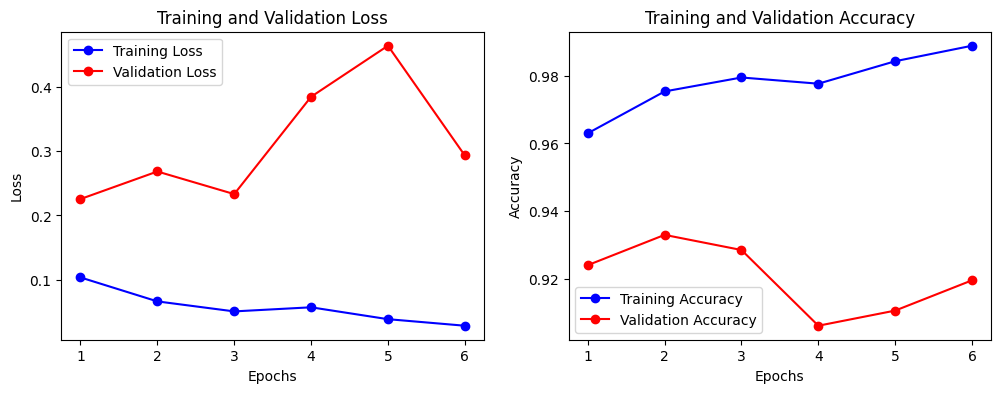

In [33]:
# Assuming you have 'history' object from model training
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs = range(1, len(training_loss) + 1)

# Plotting loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
save_path = "C:/AIProgram/saved_model.h5"  # Specify your desired save path
model.save(save_path)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os

def load_glaucoma_dataset_generator(dataset_path, image_size, batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='binary',  # Assuming it's a binary classification task
        shuffle=False  # Ensure that the order is preserved
    )

    # Retrieve the total number of samples
    num_samples = generator.samples

    return generator, num_samples

# Example usage:
your_dataset_path = r"/content/drive/MyDrive/Dataset_Latihan"
your_image_size = 224
batch_size = 32

# Define the path to the test dataset
test_dataset_path = os.path.join(your_dataset_path, 'test')

# Create a generator for the test dataset
test_generator, num_test_samples = load_glaucoma_dataset_generator(test_dataset_path, your_image_size, batch_size)

# Define the path to your pre-trained model
model_path = "/content/drive/MyDrive/Dataset_Latihan/dummy_model.h5"  # Change this to the path of your saved model

# Load the pre-trained model
loaded_model = load_model(model_path)

# Initialize variables for confusion matrix
all_true_labels = []
all_predicted_labels = []

# Threshold for classification
threshold = 0.5

# Calculate the total number of batches
total_batches = num_test_samples // batch_size

# Iterate over batches
for i in range(total_batches + 1):  # +1 to include the last batch
    batch_images, batch_labels = test_generator.next()

    # Perform predictions on the batch
    predictions = loaded_model.predict(batch_images)
    predicted_labels = (predictions > threshold).astype(int).flatten()

    # Append true and predicted labels for confusion matrix
    all_true_labels.extend(batch_labels)
    all_predicted_labels.extend(predicted_labels)

    # Calculate loading and prediction process
    process_percentage = (i + 1) / (total_batches + 1) * 100
    print(f"Processing: {process_percentage:.2f}%")

# Convert true and predicted labels to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Evaluate the model on the entire test set
test_loss, test_accuracy = loaded_model.evaluate(test_generator)

# Print test accuracy, test loss, confusion matrix, and classification report
print(f"\nTest Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
print(conf_matrix)
print("\nClassification Report:")
class_report = classification_report(all_true_labels, all_predicted_labels)
print(class_report)

# Save the confusion matrix
conf_matrix_save_path = "/content/drive/MyDrive/confusion_matrix.npy"
np.save(conf_matrix_save_path, conf_matrix)
print(f"\nConfusion Matrix saved at: {conf_matrix_save_path}")